In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from models.FITS import FITS
from torch import optim
from torch import nn
import torch
from synthgen import SyntheticDatasetGenerator

In [ ]:
# model
seq_len = 720
pred_len = 360
n_epochs = 1000
batch_size = 64
n_features = 1

# data
n_samples = int(1e4)
seasonal_period = 900

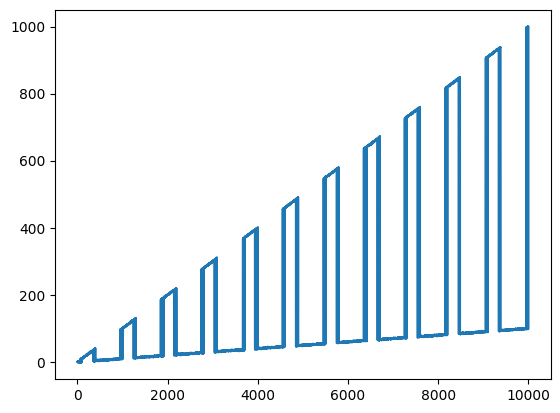

In [19]:
t = np.arange(n_samples)
seasonal_effect = 10 * np.sin(2 * np.pi * t / seasonal_period)
noise = np.random.normal(0, 1, n_samples)
data_seasonal = seasonal_effect + noise

threshold_effect = np.piecewise(
    t, [data_seasonal < 5, data_seasonal >= 5], [lambda t: t * 0.01, lambda t: t * 0.1]
)
data_threshold_effect = threshold_effect + noise

plt.plot(t, data_threshold_effect)
plt.show()

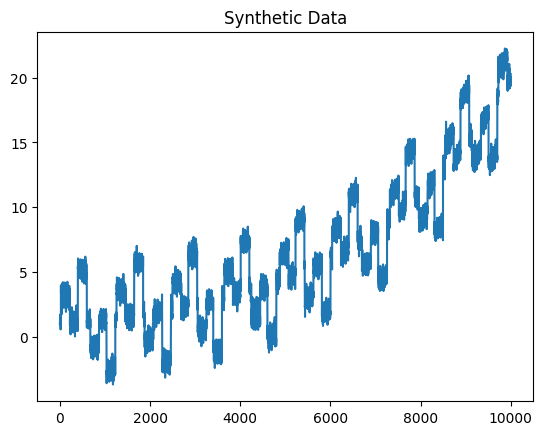

In [112]:
ds = SyntheticDatasetGenerator(length=n_samples)
# ds.add_linear_trend(slope=-50 / n_samples, intercept=0)
ds.add_sin_wave(amplitude=0.3, frequency=200)
ds.add_sin_wave(amplitude=0.3, frequency=500)
ds.add_noise(mean=0, std=0.3)
ds.add_exponential_growth(1 + (3 / n_samples))
ds.add_random_signal_with_precursor(
    precursor_amplitude=2,
    signal_amplitude=4,
    max_precursor_length=200,
    min_delay=150,
    max_delay=200,
    num_signals=int(n_samples / 500),
)
# ds.add_balanced_mean_shifts(shift_magnitude=2, num_shifts=int(length / 100))

# normalize
y = ds.data
y = (y - y.mean()) / y.std()

plt.title("Synthetic Data")
plt.plot(ds.data[:10000])
plt.show()

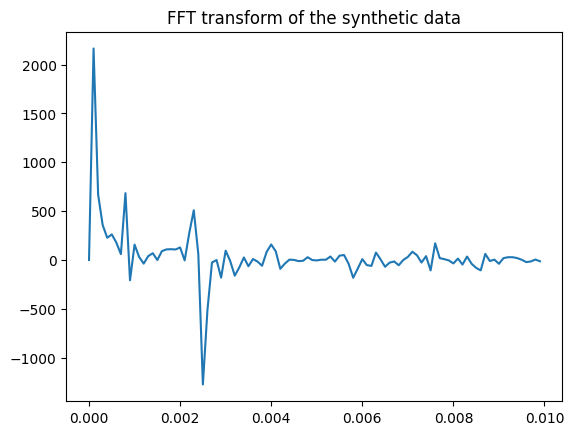

In [114]:
t = np.arange(len(y))
sp = np.fft.fft(y)
freq = np.fft.fftfreq(t.shape[-1])
plt.title("FFT transform of the synthetic data")
plt.plot(freq[:100], sp.real[:100])
plt.show()

In [34]:
@dataclass
class Config:
    dominance_freq = 50
    individual = False
    debug = False
    channels = n_features
    seq_len = seq_len
    pred_len = pred_len


model = FITS(Config)

for param in model.parameters():
    param.data.fill_(0)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [57]:
for epoch in range(n_epochs):
    order = np.random.permutation(n_samples // 2)
    train_loss = []
    for batch in range(25):
        batch_start = order[batch * batch_size : (batch + 1) * batch_size]
        batch = []
        for i in batch_start:
            batch.append(y[i : i + seq_len + pred_len])
        batch_xy = np.array(batch).reshape(batch_size, seq_len + pred_len, n_features)

        batch_xy = torch.from_numpy(batch_xy).float()

        batch_x = batch_xy[:, :seq_len, :]
        batch_y = batch_xy[:, seq_len:, :]

        model_optim.zero_grad()

        output = model(batch_x)

        loss = criterion(output, batch_xy)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    print(f"\repoch: {epoch} loss: {np.mean(train_loss):1f}", flush=True, end="")

output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

epoch: 0 loss: 0.026416

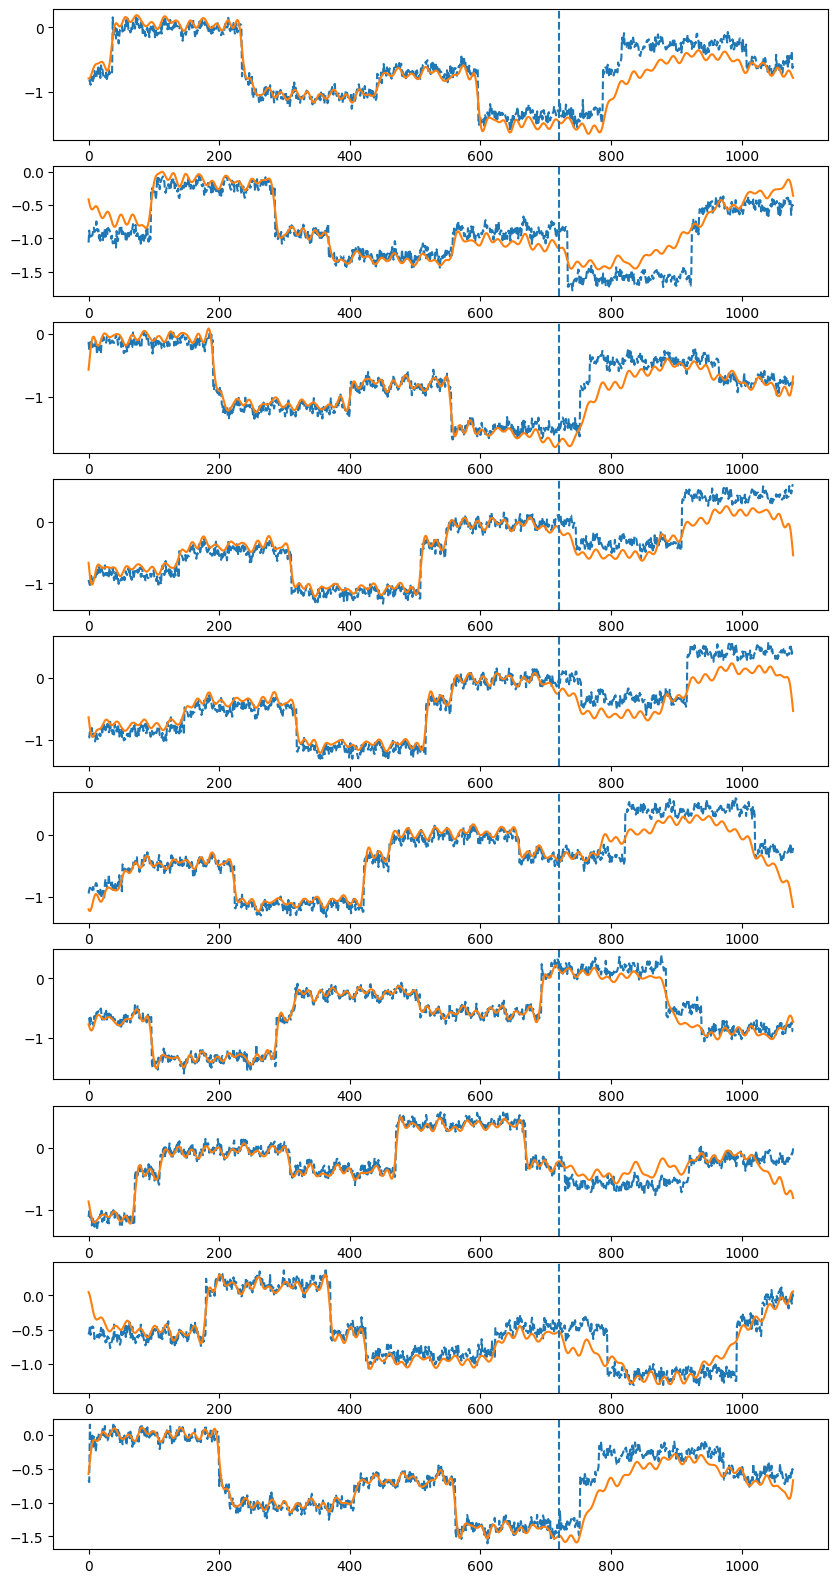

In [60]:
n_plots = 10
plt.figure(figsize=(10, 2 * n_plots))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i + 1)
    plt.plot(batch_xy[i, :, 0], "--")  # ground truth
    plt.plot(output[i, :, 0])  # prediction
    plt.axvline(seq_len, linestyle="--")

# Test set

In [54]:
with torch.no_grad():
    model.eval()
    test_loss = []
    batch = []

    for i in range(
        (n_samples // 2) + seq_len + pred_len, n_samples - seq_len - pred_len
    ):
        batch.append(y[i : i + seq_len + pred_len])
    batch_xy = np.array(batch).reshape(-1, seq_len + pred_len, 1)

    batch_xy = torch.from_numpy(batch_xy).float()

    batch_x = batch_xy[:, :seq_len, :]
    batch_y = batch_xy[:, seq_len:, :]

    model_optim.zero_grad()

    output = model(batch_x)

    loss = criterion(output, batch_xy)

    test_loss.append(loss.item())

    print("epoch: test loss: ", np.mean(test_loss))

epoch: test loss:  0.06715474277734756


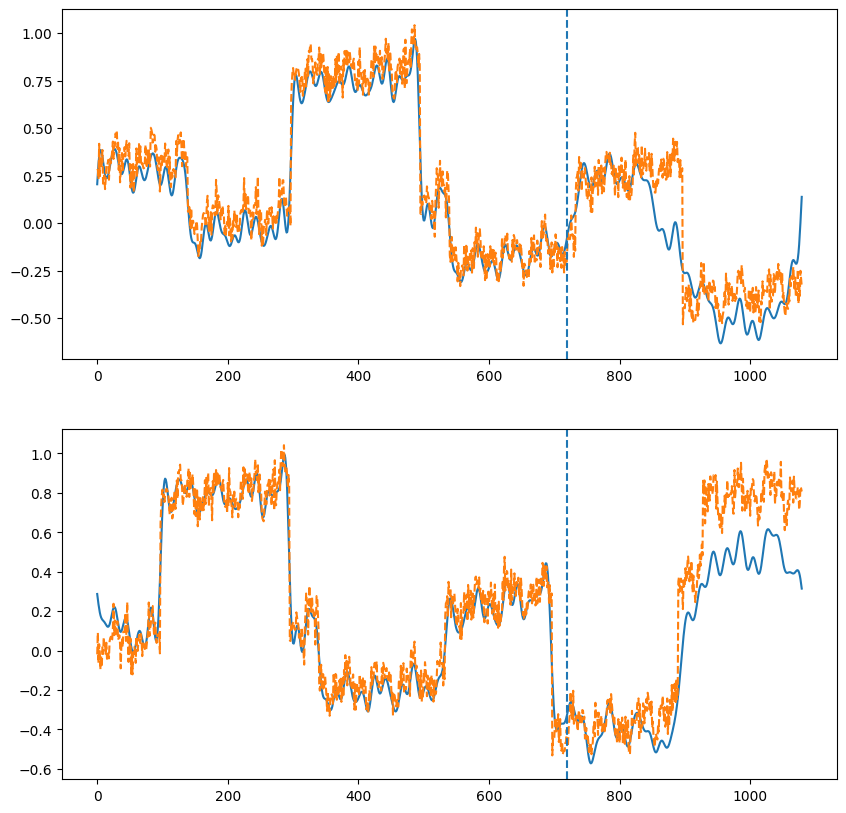

In [55]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.axvline(seq_len, linestyle="--")
plt.subplot(2, 1, 2)
plt.plot(output[200, :, 0])
plt.plot(batch_xy[200, :, 0], "--")
plt.axvline(seq_len, linestyle="--")